In [1]:
import sympy as sym
import sympy.physics.mechanics as me
from sympy.abc import t
import numpy as np
import moyra as ma
import sys, os
me.mechanics_printing()

In [2]:
DoFs = 3

# heave and fold angle as degrres of freedom
p = ma.DynamicModelParameters(DoFs)

## pendulum mass
p.m_1 = ma.ModelSymbol(value = 0.3,string = 'm_1')
p.m_2 = ma.ModelSymbol(value = 0.3,string = 'm_2')
p.EI = ma.ModelSymbol(value = 0.3,string = 'EI')

## pendulum moment of inertia
p.I_2 = ma.ModelSymbol(value = 0.3,string = 'I_2')

# pendulum length
p.L_1 = ma.ModelSymbol(value = 0.3,string = 'L_1')
p.L_2 = ma.ModelSymbol(value = 0.3,string = 'L_2')


p.y_0,p.x_0 = sym.symbols('y_0,x_0')

#gravity vector
p.g  = ma.ModelSymbol(value = 9.81,string = 'g')                     # gravity
p.g_v = ma.ModelMatrix(value =[0,0,-1],length=3,string='g_v') # The stationary point

In [3]:
#get shape functinos for flexi element
q_f = sym.Matrix([p.q[1]])
S,tau_0 = ma.elements.FlexiElement.ShapeFunctions_OBM_IBN_TO(1,0,0,q_f,p.y_0,p.x_0,0,1,type='taylor')
z_0 = (S*q_f)[2].subs({p.x_0:0})
#define refernce frames
body_1 = ma.frames.HomogenousFrame().R_x(p.q[0]).Translate(0,z_0,-p.y_0)
body_2 = body_1.subs({p.y_0:p.L_1}).R_x(p.q[2]).Translate(0,0,-p.L_2/2)

In [4]:
#Create Elemnts
# Link 1
link1_x_int = (p.x_0,sym.Rational(-1,2),sym.Rational(1,2))
link1_x_int = (p.x_0,0,1)
link1_y_int = (p.y_0,0,p.L_1)
link_1 = ma.elements.FlexiElement(p.q,body_1,p.m_1/p.L_1,S,link1_x_int,link1_y_int,0,q_f,p.EI,0,grav_vec = p.g*p.g_v,name='flexi-link')

## Link 2
link_2 = ma.elements.RigidElement(p.q,body_2,ma.elements.MassMatrix(p.m_2,I_xx=p.I_2),grav_vec = p.g*p.g_v,name='rigid-link')

In [9]:
# %%timeit -n 3 -r 1
# Create the SYmbolic Model
sm1 = ma.SymbolicModel.FromElementsAndForces(p.q,[link_1,link_2]).subs({p.g_v[0]:0,p.g_v[1]:0,p.g_v[2]:-1})

Generating EoM for Element 1 out of 2 - flexi-link:FlexiElement
Generating EoM for Element 2 out of 2 - rigid-link:RigidElement


In [10]:
# %%timeit -n 3 -r 1
# Create the SYmbolic Model
sm2 = ma.SymbolicModel.FromElementsAndForces_2(p.q,[link_1,link_2]).subs({p.g_v[0]:0,p.g_v[1]:0,p.g_v[2]:-1})

Generating EoM for Element 1 out of 2 - flexi-link:FlexiElement
Generating EoM for Element 2 out of 2 - rigid-link:RigidElement


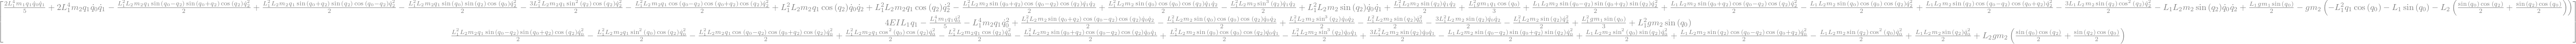

In [15]:
sm1.f

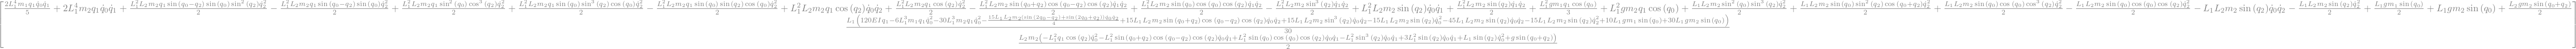

In [17]:
sym.simplify(sm2.f)

In [18]:
base_dir = "C:\\Git\\NastranMBD\\"
class_name = "flexi_pendulum_reduced"
base_class = "BaseMBD"
sm.to_matlab_class(p,base_dir,class_name,base_class)